<a href="https://colab.research.google.com/github/d61h6k4/notebooks/blob/master/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-datasets matplotlib numpy
!pip install tensorflow==2.0.0-beta1
!pip install scikit-learn

     |████████████████████████████████| 2.3MB 48.0MB/s 
     |████████████████████████████████| 87.9MB 1.6MB/s 
     |████████████████████████████████| 501kB 63.3MB/s 
     |████████████████████████████████| 3.1MB 53.8MB/s 
  Found existing installation: tensorflow 1.14.0
    Uninstalling tensorflow-1.14.0:
      Successfully uninstalled tensorflow-1.14.0


In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import tensorflow_datasets as tfds


from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [0]:
class DAWNNet(tf.keras.Model):
    def __init__(self):
        super(DAWNNet, self).__init__()
        self.__prep = tf.keras.Sequential(layers=[
            tf.keras.layers.Conv2D(64, 3, strides=1, padding="same", use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ], name='prep')
        self.__final = tf.keras.Sequential(layers=[
            tf.keras.layers.MaxPool2D(4),
            tf.keras.layers.Flatten()
        ], name='pool')
        self.__classifier = tf.keras.layers.Dense(10, activation='softmax', name='classifier')
        
    def __call__(self, inputs, training=False):
        prepeared_images = self.__prep(inputs, training)
        finalized_images = self.__final(prepeared_images, training)
        images_classes = self.__classifier(finalized_images)
        
        return images_classes

In [0]:
def preprocess_image(example):
    example['image'] = tf.image.transpose(
        tf.image.per_image_standardization(
            tf.pad(tf.cast(example['image'], tf.float32), tf.constant([[4, 4], [4, 4], [0, 0]]), "REFLECT")))
    return example

In [0]:
train = tfds.load(name='cifar10', split='train').map(preprocess_image).shuffle(buffer_size=1024).batch(64)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


W0828 04:06:08.356354 140220614272896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


W0828 04:06:14.256611 140220614272896 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/1.0.2. Subsequent calls will reuse this data.


W0828 04:06:14.365993 140220614272896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/image_ops_impl.py:1511: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [0]:
model = DAWNNet()

In [0]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)
for step, example in enumerate(train):
    with tf.GradientTape() as tape:
        logits = model(example['image'], training=True)
        loss = loss_fn(example['label'], logits)
        
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    
    if step % 100 == 0:
        print(step, float(loss))

W0828 04:06:15.192485 140220614272896 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


0 3.3847527503967285
100 1.5453683137893677
200 1.4367494583129883
300 1.3219170570373535
400 1.4205172061920166
500 1.317695140838623
600 1.2164421081542969
700 1.304185152053833


In [0]:
test = tfds.load(name='cifar10', split='test').map(preprocess_image).shuffle(buffer_size=1024).batch(128)

y_true = []
y_pred = []
for example in test:
    pred = model(example['image'])
    y_true.extend(example['label'].numpy())
    y_pred.extend(np.argmax(pred.numpy(), axis=1))
    
y_test = np.array(y_true)
y_pred = np.array(y_pred)

Confusion matrix, without normalization
[[800  26  17  48  12   7   9   8  35  38]
 [ 95 705   1  33  10   7  10  13  25 101]
 [187  21 220 175 174  69  80  56   5  13]
 [ 60  22  25 658  54  61  42  56   7  15]
 [ 86   6  25 165 528  16  65  97   8   4]
 [ 33  11  36 456  75 263  20  88   7  11]
 [ 26  15  23 224  91  18 576  16   4   7]
 [ 52   7  14 131  68  24  10 667   6  21]
 [218  81   7  59   3   5   4   7 572  44]
 [101 134   5  54  11   2   3  35  14 641]]
Normalized confusion matrix
[[0.8  0.03 0.02 0.05 0.01 0.01 0.01 0.01 0.04 0.04]
 [0.1  0.7  0.   0.03 0.01 0.01 0.01 0.01 0.03 0.1 ]
 [0.19 0.02 0.22 0.17 0.17 0.07 0.08 0.06 0.01 0.01]
 [0.06 0.02 0.03 0.66 0.05 0.06 0.04 0.06 0.01 0.01]
 [0.09 0.01 0.03 0.17 0.53 0.02 0.07 0.1  0.01 0.  ]
 [0.03 0.01 0.04 0.46 0.07 0.26 0.02 0.09 0.01 0.01]
 [0.03 0.01 0.02 0.22 0.09 0.02 0.58 0.02 0.   0.01]
 [0.05 0.01 0.01 0.13 0.07 0.02 0.01 0.67 0.01 0.02]
 [0.22 0.08 0.01 0.06 0.   0.01 0.   0.01 0.57 0.04]
 [0.1  0.13 0.01 0.05 0.

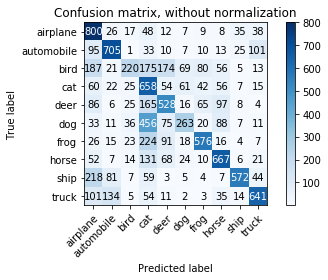

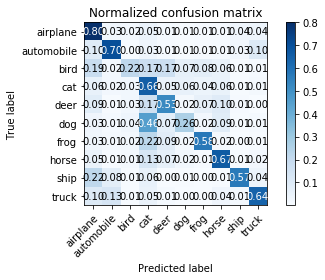

In [0]:

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']
classes = class_names

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()